The simplest way to model the data is to treat each pixel as independent and compute the probability of each being 1. Sampling is then drawing each from a Bernoulli random variable.

In [10]:
import numpy as np
import math as m
import scipy as sci
import random as ra
import functools as ft
import matplotlib.pyplot as plt

tr = np.load("train.npy")
va = np.load("valid.npy")
te = np.load("test.npy")

In [11]:
# log likelihood per example
# x : binary data set
# mu : probability of entry in that position being 1
def log_likelihood(x : np.ndarray, mu : np.ndarray) -> np.ndarray:
    return np.sum(np.log(np.where(x != 0, mu, 1 - mu)), axis=1) # Choose multiplied term based on the binary x

def sigma(x : np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x)) 

# Represent mu as sigma(Xi). This prevents us having to deal with the bounds [0,1] on probablilites.
# After some math on paper: dL/dXi_i = Sum[x_i - sigma(xi_i)]
# Compute gradient of a minibatch using weights Xi_i rather than probabilities mu.
def mini_batch_gradient(batch : np.ndarray, weights : np.ndarray) -> np.ndarray:
    return np.mean(batch - sigma(weights), axis = 0)

# Perform stochastic gradient descent on the training set, using validation set for early stopping.abs
# Return set of weights.
def do_sgd(training_set : np.ndarray, validation_set : np.ndarray, max_epochs = 200, batch_size = 500, rate = 0.02) -> np.ndarray:
    # random initialization of weights
    rng = np.random.default_rng()
    weights = sigma(rng.random(training_set[0].size))
    last_validation_ll = -m.inf
    num_batches = m.ceil(len(training_set) / batch_size)
    # do the actual SGD
    for e in range(max_epochs):
        # shuffle the training set
        perm = rng.permutation(training_set)
        for b in range(num_batches):
            weights += rate * mini_batch_gradient(training_set[b : max(b + batch_size, len(training_set))], weights)
        # stop early if the improvement in log likelihood is less than 1%
        validation_ll = np.sum(log_likelihood(validation_set, sigma(weights)))
        if(m.isclose(last_validation_ll, validation_ll, rel_tol=0.01)):
            max_epochs = e
            break
        last_validation_ll = validation_ll
    return sigma(weights)

# generate a random sample from a weight array
def sample_from_weights(mu : np.ndarray) -> np.ndarray:
    rng = np.random.default_rng()
    randoms = rng.random(mu.shape)
    return np.where(randoms < mu, 1, 0)

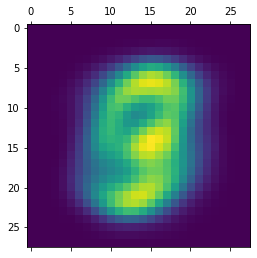

In [12]:
fb_model = do_sgd(tr, va)
plt.matshow(np.reshape(fb_model, (28, 28)))

In [13]:
np.mean(log_likelihood(te, fb_model))

-223.49408352466688

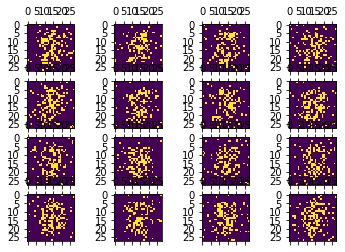

In [14]:
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_from_weights(fb_model), (28,28)))

A mixture model is a lot better. It allows the data to be split among C categories. This makes obvious sense for digits.

In [22]:
# The EM algorithm for a mixture of bernoullis.
# Returns a tuple of priors and weights we can use to generate samples.
# Validation set used for early stopping.
# Works in log space, except for probablilites.
# C is the number of categories.
def do_em(training_set : np.ndarray, validation_set : np.ndarray, C = 10) -> tuple[np.ndarray, np.ndarray]:
    # initialize: equiprobable pi, randomized mu
    D = training_set[0].size # dimensionality
    N = len(training_set) # data size
    log_pi = np.repeat(np.log(1 / C), C) # log of priors
    rng = np.random.default_rng()
    mu = rng.random((C, D)) # probablity of a 1
    log_gamma = np.empty((C, N)) # log of relative responsibility per training example
    last_validation_ll = -m.inf
    validation_ll = -m.inf
    # the EM business. stop when validation log liklihood is no longer improving
    while((not m.isfinite(validation_ll)) or not m.isclose(last_validation_ll, validation_ll, rel_tol=0.01)):
        # E step
        for c in range(C):
            log_gamma[c, :] = np.sum(np.log(np.where(training_set != 0, mu[c, :], 1 - mu[c, :])), axis=1) + log_pi[c]
        log_gamma -= sci.special.logsumexp(log_gamma, axis=0)
            
        # M step
        gamma = np.exp(log_gamma)
        mu = np.matmul(gamma, training_set)
        mu /= np.sum(gamma, axis=1, keepdims=True)
  
        log_pi = sci.special.logsumexp(log_gamma, axis=1) - np.log(N)

        last_validation_ll = validation_ll
        validation_ll = mixture_log_likelihood(validation_set, mu, log_pi)
    return (log_pi, mu)

# log likelihood for mixture model (average)
def mixture_log_likelihood(data : np.ndarray, mu : np.ndarray, log_pi : np.ndarray) -> np.ndarray:
    ll = np.apply_along_axis(ft.partial(log_likelihood, te), axis=1, arr=mu)
    ll += log_pi[:, np.newaxis]
    log_pr = sci.special.logsumexp(ll, axis=0)
    log_pr = log_pr[np.isfinite(log_pr)] # filter out the infs
    return np.mean(log_pr)

# generate a random sample from a weight array by selecting category from prior probabilities
def sample_from_weights_and_category(mu : np.ndarray, pi : np.ndarray) -> np.ndarray:
    return sample_from_weights(ra.choices(mu, pi)[0])

/tmp/ipykernel_559/1987885308.py:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.where(x != 0, mu, 1 - mu)), axis=1) # Choose multiplied term based on the binary x
/tmp/ipykernel_559/3973787027.py:20: RuntimeWarning: divide by zero encountered in log
  log_gamma[c, :] = np.sum(np.log(np.where(training_set != 0, mu[c, :], 1 - mu[c, :])), axis=1) + log_pi[c]


<BarContainer object of 10 artists>

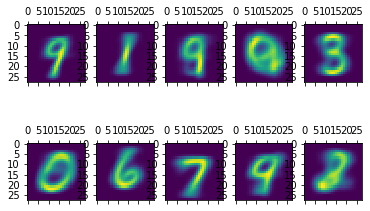

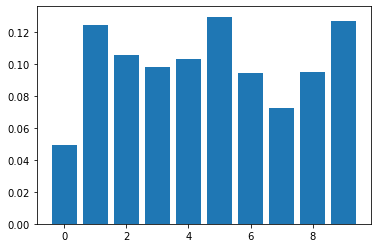

In [23]:
categories = 10
mix_log_pi, mix_mu = do_em(tr, va, C=categories)
fig, axs = plt.subplots(2, 5)
for i in range(categories):
    axs[i // 5, i % 5].matshow(np.reshape(mix_mu[i], (28, 28)))
plt.figure()
plt.bar(np.arange(categories), np.exp(mix_log_pi))

In [24]:
mixture_log_likelihood(te, mix_mu, mix_log_pi)

/tmp/ipykernel_559/1987885308.py:5: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(np.where(x != 0, mu, 1 - mu)), axis=1) # Choose multiplied term based on the binary x


-170.56783099465048

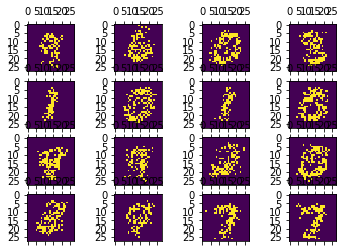

In [25]:
mix_pi = np.exp(mix_log_pi)
fig, axs = plt.subplots(4, 4)
for i in range(16):
    axs[i // 4, i % 4].matshow(np.reshape(sample_from_weights_and_category(mix_mu, mix_pi), (28, 28)))